# Flame Speed with Sensitivity Analysis
In this example we simulate a freely-propagating, adiabatic, 1-D flame, calculate its laminar burning velocity and perform a sensitivity analysis of its kinetics.

The figure below illustrates the setup, in a flame-fixed co-ordinate system. The reactants enter with density $\rho_{u}$, temperature $T_{u}$ and speed $S_{u}$. The products exit the flame at speed $S_{b}$, density $\rho_{b}$ and temperature $T_{b}$.

<img src="images/flameSpeed.png" alt="Freely Propagating Flame" style="width: 300px;"/>

### Import Modules

In [1]:
import cantera as ct
import numpy as np
import pandas as pd

print(f"Running Cantera Version: {ct.__version__}")

Running Cantera Version: 2.6.0a4


In [2]:
# Import plotting modules and define plotting preference
%config InlineBackend.figure_formats = ["svg"]
%matplotlib inline
import matplotlib.pylab as plt

plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["figure.dpi"] = 120

# Get the best of both ggplot and seaborn
plt.style.use("ggplot")
plt.style.use("seaborn-deep")

plt.rcParams["figure.autolayout"] = True

### Define the reactant conditions, gas mixture and kinetic mechanism associated with the gas

In [3]:
# Inlet Temperature in Kelvin and Inlet Pressure in Pascals
# In this case we are setting the inlet T and P to room temperature conditions
To = 300
Po = 101325

# Define the gas-mixutre and kinetics
# In this case, we are choosing a GRI3.0 gas
gas = ct.Solution("gri30.yaml")

# Create a stoichiometric CH4/Air premixed mixture
gas.set_equivalence_ratio(1.0, "CH4", {"O2": 1.0, "N2": 3.76})
gas.TP = To, Po

### Define flame simulation conditions

In [4]:
# Domain width in metres
width = 0.014

# Create the flame object
flame = ct.FreeFlame(gas, width=width)

# Define tolerances for the solver
flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)

# Define logging level
loglevel = 1

### Solve

In [5]:
flame.solve(loglevel=loglevel, auto=True)
Su0 = flame.velocity[0]
print(f"Flame Speed is: {Su0 * 100:.2f} cm/s")

# Note that the variable Su0 will also be used downstream in the sensitivity analysis


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.136e-05      5.453
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0003649      4.427
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     1.624e-05      6.029
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     3.468e-05      5.674
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.001333      4.122
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accommodate flame thickness. New width: 0.028 m
##############################################################################
Refining grid in flame.
    New points inserted after gri

### Plot figures

Check and see if all has gone well. Plot temperature and species fractions to see

#### Temperature Plot

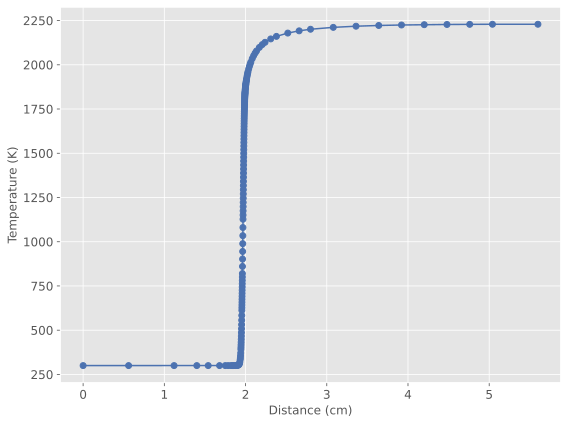

In [6]:
plt.figure()

plt.plot(flame.grid * 100, flame.T, "-o")
plt.xlabel("Distance (cm)")
plt.ylabel("Temperature (K)");

#### Major species' plot

To plot species, we first have to identify the index of the species in the array.
For this, cut & paste the following lines and run in a new cell to get the index

```python
for i, specie in enumerate(gas.species()):
    print(f"{i}. {specie}")
```

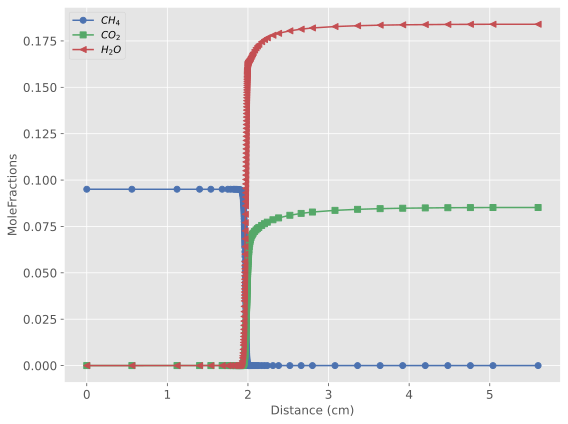

In [7]:
# Extract concentration data
X_CH4 = flame.X[13]
X_CO2 = flame.X[15]
X_H2O = flame.X[5]

plt.figure()

plt.plot(flame.grid * 100, X_CH4, "-o", label="$CH_{4}$")
plt.plot(flame.grid * 100, X_CO2, "-s", label="$CO_{2}$")
plt.plot(flame.grid * 100, X_H2O, "-<", label="$H_{2}O$")

plt.legend(loc=2)
plt.xlabel("Distance (cm)")
plt.ylabel("MoleFractions");

## Sensitivity Analysis

See which reactions effect the flame speed the most

In [8]:
# Create a dataframe to store sensitivity-analysis data
sensitivities = pd.DataFrame(index=gas.reaction_equations(), columns=["base_case"])

### Compute sensitivities

In [9]:
# Set the value of the perturbation
dk = 1e-2

In [10]:
for m in range(gas.n_reactions):
    gas.set_multiplier(1.0)  # reset all multipliers
    gas.set_multiplier(1 + dk, m)  # perturb reaction m

    # Always force loglevel=0 for this
    # Make sure the grid is not refined, otherwise it won't strictly
    # be a small perturbation analysis
    # Turn auto-mode off since the flame has already been solved
    flame.solve(loglevel=0, refine_grid=False, auto=False)

    # The new flame speed
    Su = flame.velocity[0]

    sensitivities.iloc[m, 0] = (Su - Su0) / (Su0 * dk)

# This step is essential, otherwise the mechanism will have been altered
gas.set_multiplier(1.0)

In [11]:
sensitivities.head()

,base_case
2 O + M <=> O2 + M,0.00157
H + O + M <=> OH + M,0.001112
H2 + O <=> H + OH,0.025264
HO2 + O <=> O2 + OH,0.003139
H2O2 + O <=> HO2 + OH,0.000755


### Make plots

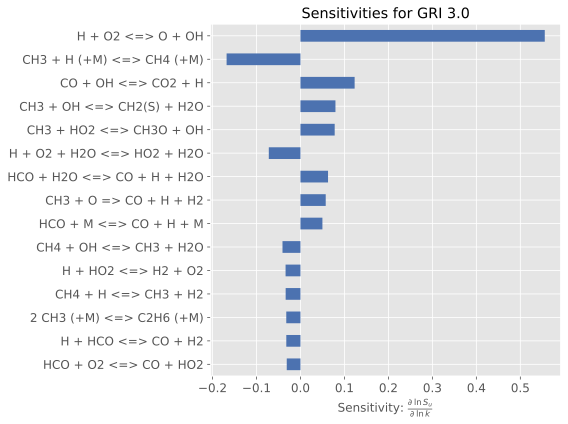

In [12]:
# Reaction mechanisms can contains thousands of elementary steps. Choose a threshold
# to see only the top few
threshold = 0.03

# For plotting, collect only those steps that are above the threshold
# Otherwise, the y-axis gets crowded and illegible
sensitivities_subset = sensitivities[sensitivities["base_case"].abs() > threshold]
reactions_above_threshold = (
    sensitivities_subset.abs().sort_values(by="base_case", ascending=False).index
)
sensitivities_subset.loc[reactions_above_threshold].plot.barh(
    title="Sensitivities for GRI 3.0", legend=None
)
plt.gca().invert_yaxis()

plt.rcParams.update({"axes.labelsize": 20})
plt.xlabel(r"Sensitivity: $\frac{\partial\:\ln{S_{u}}}{\partial\:\ln{k}}$");

# Uncomment the following to save the plot. A higher than usual resolution (dpi) helps
# plt.savefig('sensitivityPlot', dpi=300)